In [1]:
from io import StringIO
import os

import boto3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', 30)

In [2]:
aws_access_key_id = os.getenv('AWS_ACCESS_KEY')
aws_secret_key = os.getenv('AWS_SECRET_KEY')

In [3]:
def read_csv_from_s3(bucket: str, path: str, filename: str) -> pd.DataFrame:
    """Downloads a csv file from an S3 bucket.
    
    Args:
        bucket (str): The bucket where the files at.
        path (str): The folder of the files.
        filename (str): Name of the file.

    Returns:
        pd.DataFrame: A DataFrame of the downloaded file.
    """
    
    s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_key)
    
    full_path = f'{path}{filename}'
    
    object = s3.get_object(Bucket=bucket, Key=full_path)
    object = object['Body'].read().decode('utf-8')
    output_df = pd.read_csv(StringIO(object))
    
    return output_df

In [4]:
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_key)
bucket = 'chicago-taxi-data-project-dzs'

community_areas_path = 'transformed_data/community_areas/'
company_path = 'transformed_data/company/'
date_path = 'transformed_data/date/'
payment_type_path = 'transformed_data/payment_type/'
taxi_trips_path = 'transformed_data/taxi_trips/'
weather_path = 'transformed_data/weather/'


In [5]:
community_areas = read_csv_from_s3(bucket, community_areas_path, 'community_areas_master.csv')
company = read_csv_from_s3(bucket, company_path, 'company_map_table.csv')
date = read_csv_from_s3(bucket, date_path, 'date_dimension.csv')
payment_type = read_csv_from_s3(bucket, payment_type_path, 'payment_type_map_table.csv')

In [6]:
trips_list = []
weather_list = []

In [7]:
for file in s3.list_objects(Bucket=bucket, Prefix=taxi_trips_path)['Contents']:
    taxi_trips_key = file['Key']
    if taxi_trips_key.split('/')[-1].strip() == '':
        continue
    if taxi_trips_key.split('.')[1] == 'csv':
        
        filename = taxi_trips_key.split('/')[-1]
        trip = read_csv_from_s3(bucket, taxi_trips_path, filename)

        trips_list.append(trip)

            

In [8]:
trips = pd.concat(trips_list, ignore_index=True)

In [9]:
for file in s3.list_objects(Bucket=bucket, Prefix=weather_path)['Contents']:
    weather_key = file['Key']
    if weather_key.split('/')[-1].strip() == '':
        continue
    if weather_key.split('.')[1] == 'csv':
        
        filename = weather_key.split('/')[-1]
        weather_daily = read_csv_from_s3(bucket, weather_path, filename)

        weather_list.append(weather_daily)


In [10]:
weather = pd.concat(weather_list, ignore_index=True)

In [11]:
weather.head()

,datetime,temperature,wind_speed,rain,precipitation
0,2024-02-07 00:00:00,2.5,10.0,0.0,0.0
1,2024-02-07 01:00:00,0.5,11.1,0.0,0.0
2,2024-02-07 02:00:00,0.2,12.0,0.0,0.0
3,2024-02-07 03:00:00,-0.1,13.1,0.0,0.0
4,2024-02-07 04:00:00,-0.4,12.1,0.0,0.0


### Join tables together

In [12]:
trips_full = pd.merge(trips, weather, left_on='datetime_for_weather', right_on='datetime', how='inner')
trips_full = trips_full.drop(columns=['datetime_for_weather'])

In [13]:
trips_full = pd.merge(trips_full, company, on='company_id', how='inner')
trips_full = trips_full.drop(columns=['company_id'])

In [14]:
trips_full = pd.merge(trips_full, payment_type, on='payment_type_id', how='inner')
trips_full = trips_full.drop(columns=['payment_type_id'])

In [15]:
trips_full = pd.merge(trips_full, community_areas, left_on='pickup_community_area_id', right_on='area_code', how='inner')
trips_full = trips_full.drop(columns=['pickup_community_area_id', 'area_code'])
trips_full = trips_full.rename(columns={'community_name': 'pickup_community_area'})

In [16]:
trips_full = pd.merge(trips_full, community_areas, left_on='dropoff_community_area_id', right_on='area_code', how='inner')
trips_full = trips_full.drop(columns=['dropoff_community_area_id', 'area_code'])
trips_full = trips_full.rename(columns={'community_name': 'dropoff_community_area'})

In [17]:
date['date'] = pd.to_datetime(date['date'])
trips_full['trip_start_timestamp'] = pd.to_datetime(trips_full['trip_start_timestamp'])
trips_full['trip_start_date'] = trips_full['trip_start_timestamp'].dt.date
trips_full['trip_start_date'] = pd.to_datetime(trips_full['trip_start_date'])

In [18]:
trips_full = pd.merge(trips_full, date, left_on='trip_start_date', right_on='date', how='inner')
trips_full = trips_full.drop(columns=['date'])

In [19]:
trips_full.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,...,temperature,wind_speed,rain,precipitation,company,payment_type,pickup_community_area,dropoff_community_area,trip_start_date,year,month,day,dayofweek,daynames,is_weekend
0,975d384f93d355509aed157241d6a10820ea2e87,de9289a1fce135051f6e9206044f8211c86a1a6acd68d4...,2024-02-07 23:45:00,2024-02-08T00:00:00.000,1555,17.81,44.50,0.00,0.0,5.0,50.00,41.980264,-87.913625,41.878914,-87.705897,...,6.5,13.7,0.0,0.0,Flash Cab,Credit Card,O'Hare,East Garfield Park,2024-02-07,2024,2,7,3,Wednesday,False
1,fcf107546e3490214f8e53e4c8cc9706879b98c7,e64ae81fa38a2e8716a35dfa4e316dddd2eda286f5824e...,2024-02-07 23:45:00,2024-02-08T01:00:00.000,4403,5.61,19.00,0.00,0.0,0.0,19.00,41.874005,-87.663518,41.953582,-87.723452,...,6.5,13.7,0.0,0.0,Sun Taxi,Cash,Near West Side,Irving Park,2024-02-07,2024,2,7,3,Wednesday,False
2,f693f952546fbf3046542d7d33ea976b0ead34fd,dec67a4fc6ba6a0b279c4f8ebaba8c9c160e469d03cb20...,2024-02-07 23:45:00,2024-02-07T23:45:00.000,12,0.00,35.00,5.32,0.0,0.0,40.82,41.899602,-87.633308,41.899602,-87.633308,...,6.5,13.7,0.0,0.0,Flash Cab,Credit Card,Near North Side,Near North Side,2024-02-07,2024,2,7,3,Wednesday,False
3,efd4a1a593254802fab1ad26cd329cb1996485a0,5d7801992a88d2d1340e703e6ff8efd44302443c3e4058...,2024-02-07 23:45:00,2024-02-08T00:00:00.000,729,2.21,9.75,0.00,0.0,0.0,9.75,41.874005,-87.663518,41.878866,-87.625192,...,6.5,13.7,0.0,0.0,5 Star Taxi,Cash,Near West Side,Loop,2024-02-07,2024,2,7,3,Wednesday,False
4,ef211629e588f2c85baa3735d37be475be2ac06d,3b443d58fee461cd803cdf9a032f474964aabb042fc5f6...,2024-02-07 23:45:00,2024-02-07T23:45:00.000,7,0.00,30.00,0.00,0.0,0.0,30.50,41.980264,-87.913625,41.980264,-87.913625,...,6.5,13.7,0.0,0.0,City Service,Credit Card,O'Hare,O'Hare,2024-02-07,2024,2,7,3,Wednesday,False


#### Count plot, bar plot

Text(0.5, 0, 'Day of the Week')

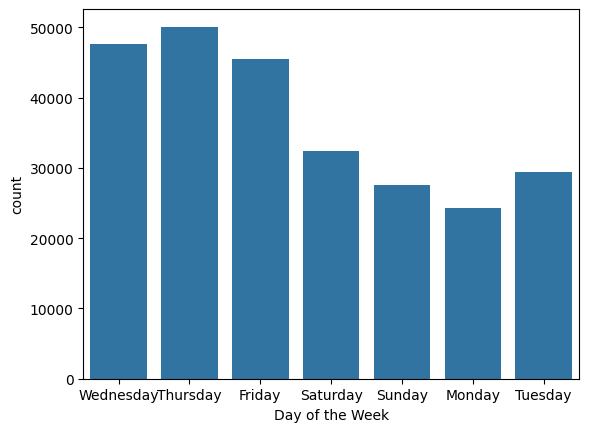

In [23]:
sns.countplot(x ='daynames', data = trips_full)
plt.xlabel('Day of the Week')

Text(0.5, 0, 'Payment Type')

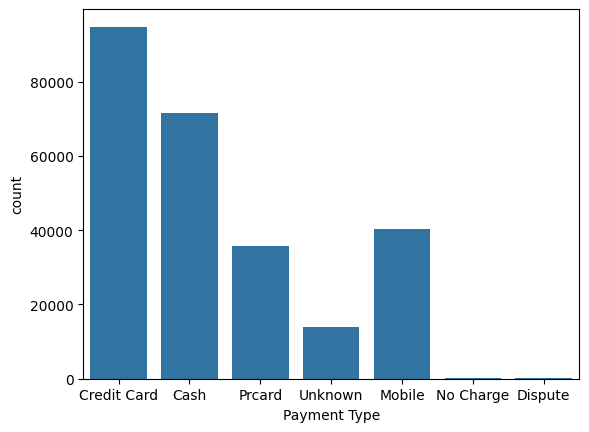

In [24]:
sns.countplot(x ='payment_type', data = trips_full)
plt.xlabel('Payment Type')

Text(0.5, 0, 'Payment Type')

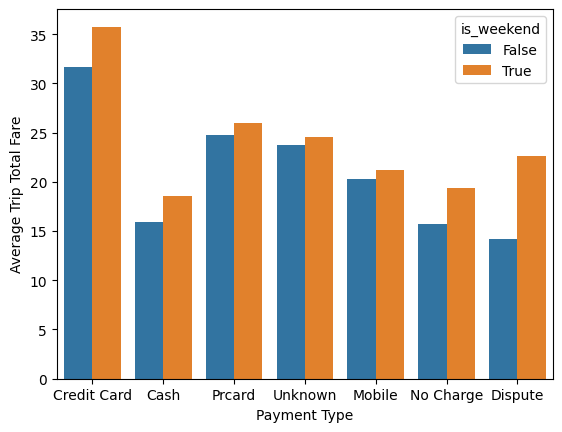

In [39]:
sns.barplot(data=trips_full, x='payment_type', y='trip_total', hue='is_weekend', estimator='mean', errorbar=None)
plt.ylabel('Average Trip Total Fare')
plt.xlabel('Payment Type')

Text(0, 0.5, 'Number of Trips')

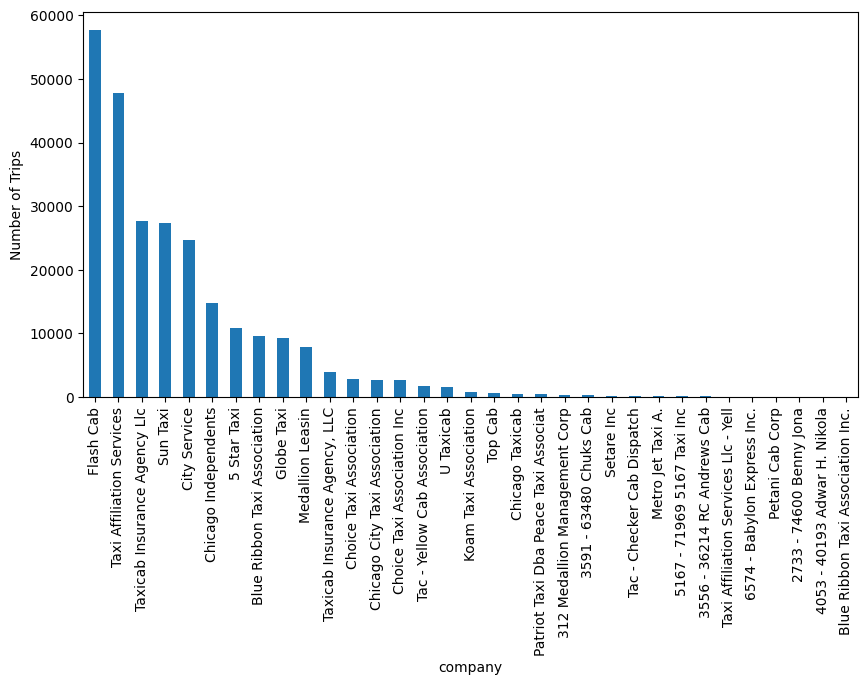

In [31]:
trips_full['company'].value_counts().plot(kind='bar', figsize=(10,5))
plt.ylabel('Number of Trips')

#### Detecting outliers by boxplot

Text(0, 0.5, 'Payment Type')

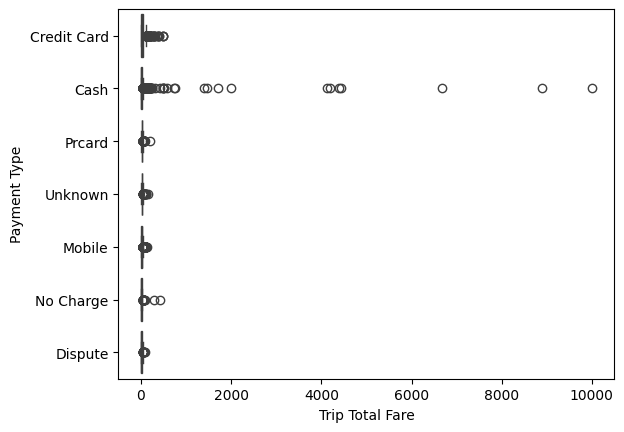

In [33]:
sns.boxplot(data=trips_full, x='trip_total', y='payment_type')
plt.xlabel('Trip Total Fare')
plt.ylabel('Payment Type')